# Content Based Recomendation System

## Declaration of Library

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

## Upload dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving tourism_with_id.csv to tourism_with_id.csv


## Load the Dataset

In [40]:
# Reading the file
df = pd.read_csv("tourism_with_id.csv")

#Reading the first five records
df.head()

#Checking the shape of the file
#df.shape()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


## Exploratory Data Analysis

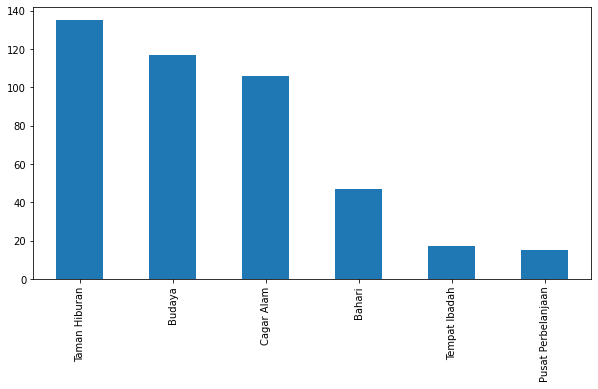

In [4]:
# Genre distribution
df['Category'].value_counts().plot(x = 'Category', y ='count', kind = 'bar', figsize = (10,5))

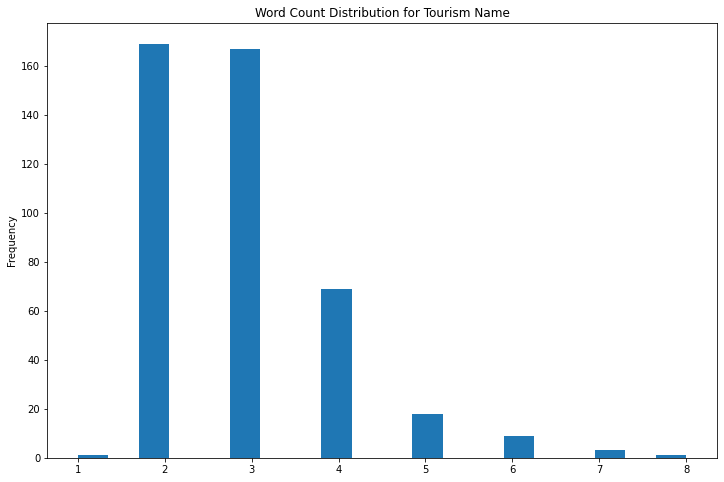

In [5]:
df['word_count'] = df['Place_Name'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 20,
    figsize = (12,8),title='Word Count Distribution for Tourism Name')

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

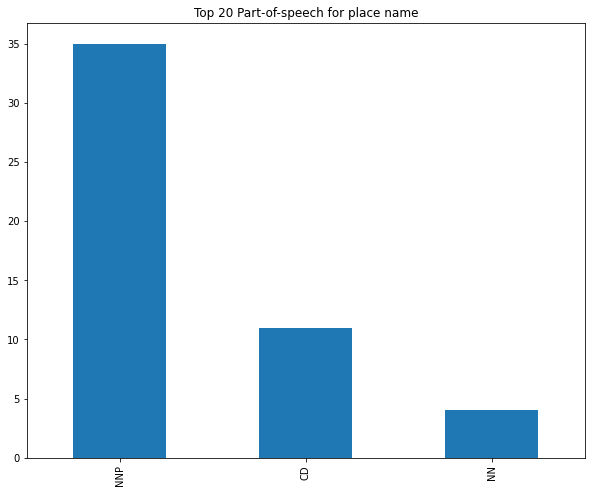

In [8]:
from textblob import TextBlob
blob = TextBlob(str(df['Place_Name']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech for place name")

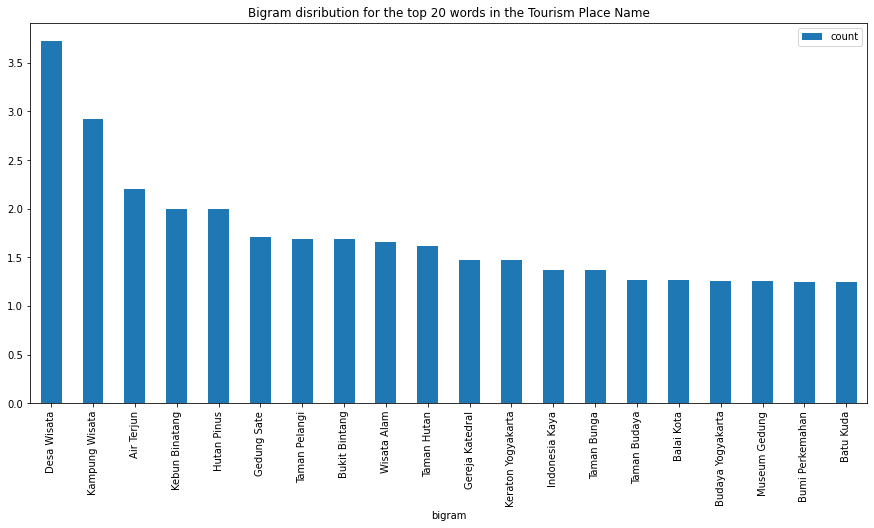

In [10]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Place_Name'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the Tourism Place Name", figsize = (15,7), )

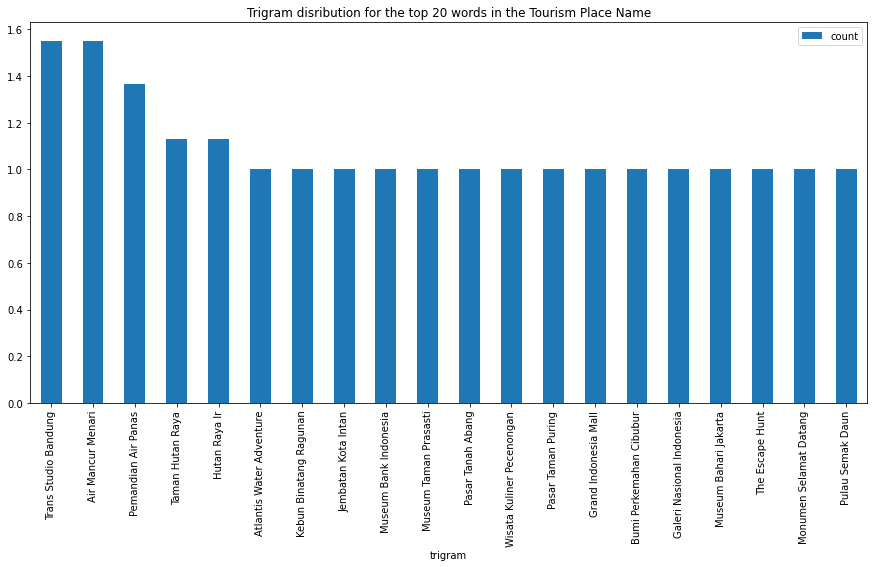

In [12]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Place_Name'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the Tourism Place Name", figsize = (15,7), )

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
df['cleaned_desc'] = df['Place_Name'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)

## Function to recomendation system based on content

In [38]:
# Function for recommending tourist destinations based on place name. It takes place name and category as an input.def recommend(place_name, category):
from sklearn.metrics.pairwise import cosine_similarity    
    # Matching the category with the dataset and reset the index
category = df['Category']
City = df['City']

def recommend(place_name, category):
  data = df.loc[df['Category'] == category]  
  data.reset_index(level = 0, inplace = True) 
  place_name = data['Place_Name']
    # Convert the index into series
  indices = pd.Series(data.index, index = data['Place_Name'])
    
    #Converting the place name into vectors and used bigram
  tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
  tfidf_matrix = tf.fit_transform(data['Place_Name'])
    
    # Calculating the similarity measures based on Cosine Similarity
  sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to place name

  idx = indices[place_name]# Get the pairwsie similarity scores 
  sig = list(enumerate(sg[idx]))# Sort the names
  sig = sorted(sig, key=lambda x: x[1][0], reverse=True)# Scores of the 5 most similar books 
  sig = sig[1:6]# Book indicies
  tourist_indices = [i[0] for i in sig]
   
    # Top 5 tourist recommendation
  rec = data[['Place_Name', 'Category']].iloc[tourist_indices]
  print(rec)     
    # It reads the top 5 recommended Place and print the images
  #rec  
  #for i in rec['Place_Name','Category']:
      #print(i)
      #img = Image.open(BytesIO(response.content))
      #plt.figure()
      #print(plt.imshow(img))

In [39]:
recommend("Kota Tua", "Budaya")

              Place_Name Category
1               Kota Tua   Budaya
2    Jembatan Kota Intan   Budaya
3      Museum Fatahillah   Budaya
4  Museum Bank Indonesia   Budaya
5  Museum Taman Prasasti   Budaya
